In [31]:
pip install scikit-learn==1.6.1

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [32]:
!python --version

Python 3.13.5


In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib


In [34]:
#Load Dataset
df = pd.read_csv("insurance (1).csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [35]:
#Basic Data Understanding
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [36]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [37]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

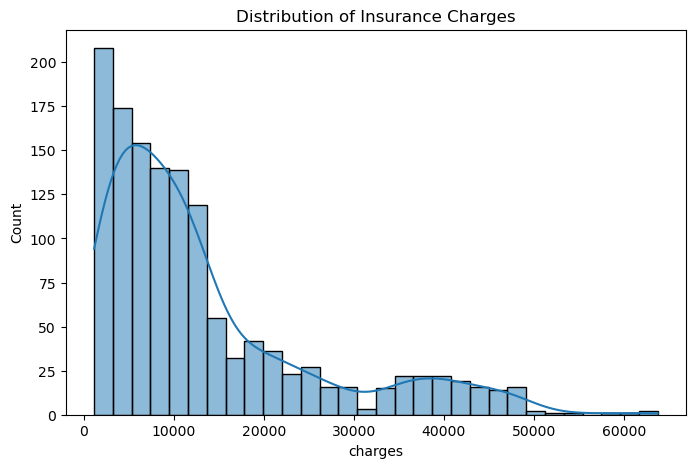

In [38]:
#EDA - Target Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['charges'],kde=True)
plt.title("Distribution of Insurance Charges")
plt.show()

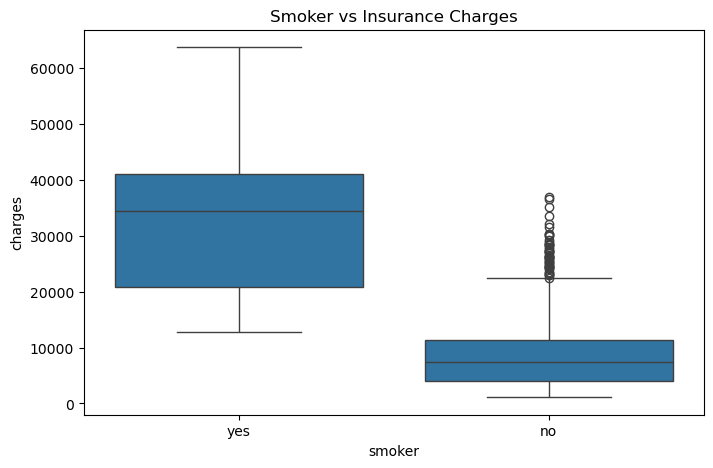

In [39]:
#EDA - Smoker Vs Charges
plt.figure(figsize=(8,5))
sns.boxplot(x='smoker', y='charges',data=df)
plt.title('Smoker vs Insurance Charges')
plt.show()

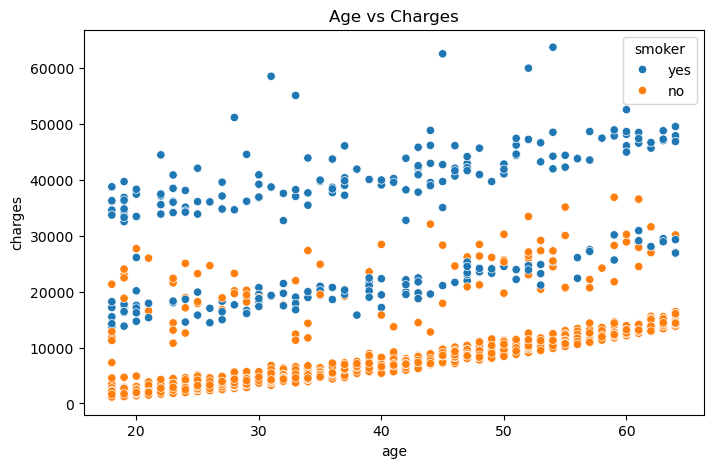

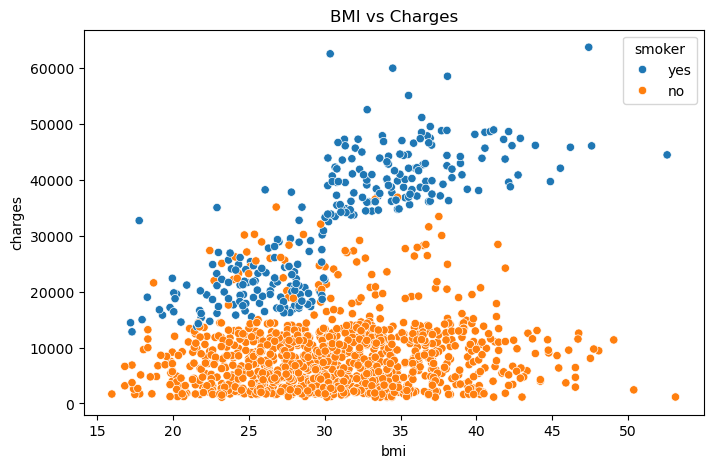

In [40]:
# EDA - Age & BMI Impact
plt.figure(figsize=(8,5))
sns.scatterplot(x='age', y='charges', hue='smoker',data=df)
plt.title('Age vs Charges')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x='bmi', y='charges', hue='smoker',data=df)
plt.title('BMI vs Charges')
plt.show()

In [41]:
#Features & Target Split
X=df.drop('charges',axis=1)
y=df['charges']


In [42]:
#Feature Engineering(Encoding+Scalling)
categorical_features =['sex','smoker','region']
numerical_features = ['age','bmi','children']

preprocessor = ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numerical_features),
        ('cat',OneHotEncoder(drop='first'),categorical_features)
    ]
)

In [43]:
X_train,X_test,y_train,y_test=train_test_split(
    X,y, test_size=0.2,random_state=42
)

In [44]:
#models Dictionary
models ={
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Randome Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

In [45]:
#model Training + evalurtion
results=[]

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('model',model)
    ])

pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)

results.append([name,mae,rmse,r2])

In [46]:
# Model Comparison Table
results_df = pd.DataFrame(
    results,columns=['Model','MAE','RMSE','R2 Score']
).sort_values(by='R2 Score', ascending=False)

results_df

,Model,MAE,RMSE,R2 Score
0,Gradient Boosting,2443.483262,4329.570011,0.879257


In [47]:
#select Best Model
best_model_name = results_df.iloc[0]['Model']
best_model_name

best_model = models[best_model_name]

final_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',best_model)
])

final_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [48]:
#Save Best Model(JOBLIB)
joblib.dump(final_pipeline,'insurance_best_model.joblib')
#Production-redy model saved

['insurance_best_model.joblib']

In [49]:
#Predictions on Original Data
df['predicted_charges'] = final_pipeline.predict(X) 
df.head()

,age,sex,bmi,children,smoker,region,charges,predicted_charges
0,19,female,27.900,0,yes,southwest,16884.92400,18341.750400
1,18,male,33.770,1,no,southeast,1725.55230,4150.288778
2,28,male,33.000,3,no,southeast,4449.46200,6606.485726
3,33,male,22.705,0,no,northwest,21984.47061,6315.690799
4,32,male,28.880,0,no,northwest,3866.85520,3901.008258


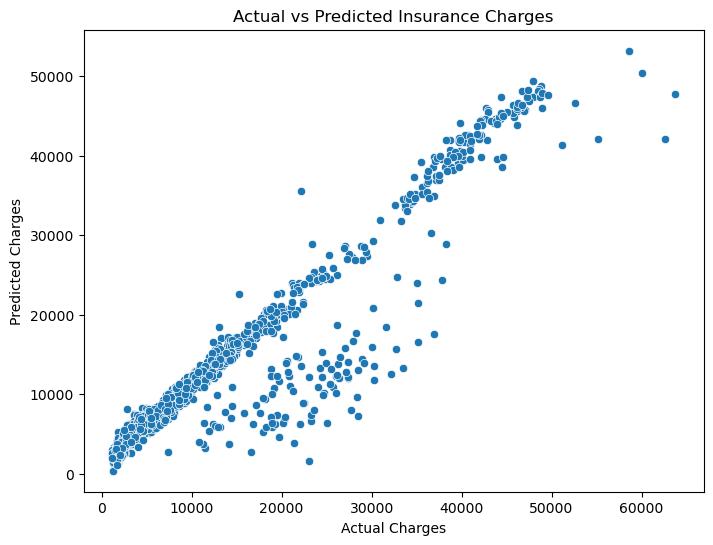

In [50]:
#Visual Comparison - Original vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y, y=df['predicted_charges'])
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title("Actual vs Predicted Insurance Charges")
plt.show()

In [51]:
#New Data Prediction Example
new_data = pd.DataFrame({
    'age': [40],
    'sex': ['male'],
    'bmi': [28.5],
    'children': [2],
    'smoker': ['yes'],
    'region': ['southeast']
})

prediction = final_pipeline.predict(new_data)
prediction


array([22012.77128227])

“The model performs well on majority cases, but struggles with rare high-cost non-smoker cases due to missing medical history features. This highlights real-world data limitations.”